In [83]:
import pandas as pd
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer
)
    
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import seaborn as sns

from lemma_tokenizer import LemmaTokenizer

In [84]:
wine = pd.read_csv("dataset_sampled.csv")
wine = wine.drop(columns = ["Unnamed: 0"])
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


<AxesSubplot:title={'center':'Lable Distribution'}, ylabel='Frequency'>

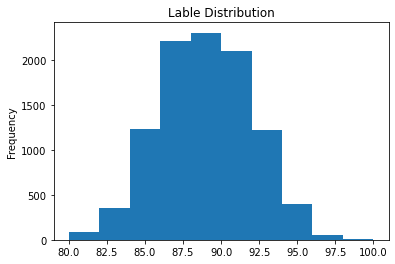

In [290]:
wine["points"].plot.hist(title = "Lable Distribution")

### Investigate Missing values

Example count 10000
country NaN: 6
Equal to 0.06%
--------------------
description NaN: 0
Equal to 0.0%
--------------------
designation NaN: 2829
Equal to 28.29%
--------------------
points NaN: 0
Equal to 0.0%
--------------------
price NaN: 677
Equal to 6.77%
--------------------
province NaN: 6
Equal to 0.06%
--------------------
region_1 NaN: 1664
Equal to 16.64%
--------------------
region_2 NaN: 6147
Equal to 61.47%
--------------------
taster_name NaN: 1985
Equal to 19.85%
--------------------
taster_twitter_handle NaN: 2356
Equal to 23.56%
--------------------
title NaN: 0
Equal to 0.0%
--------------------
variety NaN: 0
Equal to 0.0%
--------------------
winery NaN: 0
Equal to 0.0%
--------------------


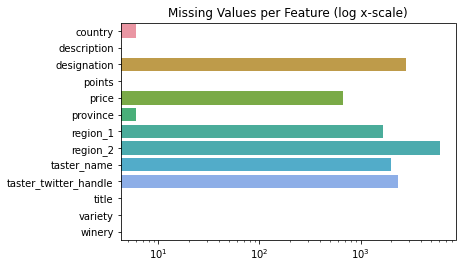

In [65]:
def nan_info(data:pd.DataFrame, columns_name:str) -> int:
    nan_count = len(data[data[columns_name].isna()])
    print(f"{columns_name} NaN: {nan_count}")
    print(f"Equal to {(nan_count/len(data))*100}%")
    print("-"*20)
    return nan_count

print(f"Example count {len(wine)}")

nan_counts = []

for col in wine.columns:
    nan_counts.append(nan_info(wine, col))

ax = sns.barplot(y = wine.columns, x  = nan_counts)
ax.set_title("Missing Values per Feature (log x-scale)")
ax.set_xscale("log")

In [216]:
# Designation has to many missing values, thus is not suiteable for a prediction
# Same for region_1 and region_2
# The title will also be neglected, as it is hard to draw any correlations from it, since it is individual for each wine
wine[(wine["taster_name"].isna()) & (~wine["taster_twitter_handle"].isna())]

'99.3% of wine have a unique name'

#### Filling missing Taster names

In [40]:
# See if taster name can be filled by using the corresponding twitter handle
# They can not, sadly
wine[(wine["taster_name"].isna()) & (~wine["taster_twitter_handle"].isna())]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery


#### Fill missing prices

Text(0.5, 1.0, 'Missing Prices per Country')

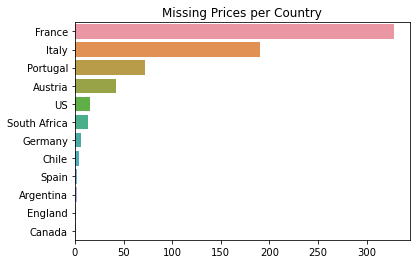

In [95]:
## The plan is to fill the prices by the countries price average
## Investigating the countries of the missing prices
price_to_country = wine[wine["price"].isna()].country.value_counts()

ax = sns.barplot(y = price_to_country.index, x  = price_to_country.values)
ax.set_title("Missing Prices per Country")

In [222]:
wine[wine["price"].isna()].country.unique()

array(['Italy', 'France', 'Austria', 'US', 'Chile', 'Portugal', 'Germany',
       'Canada', 'South Africa', 'Spain', 'Argentina', nan, 'England'],
      dtype=object)

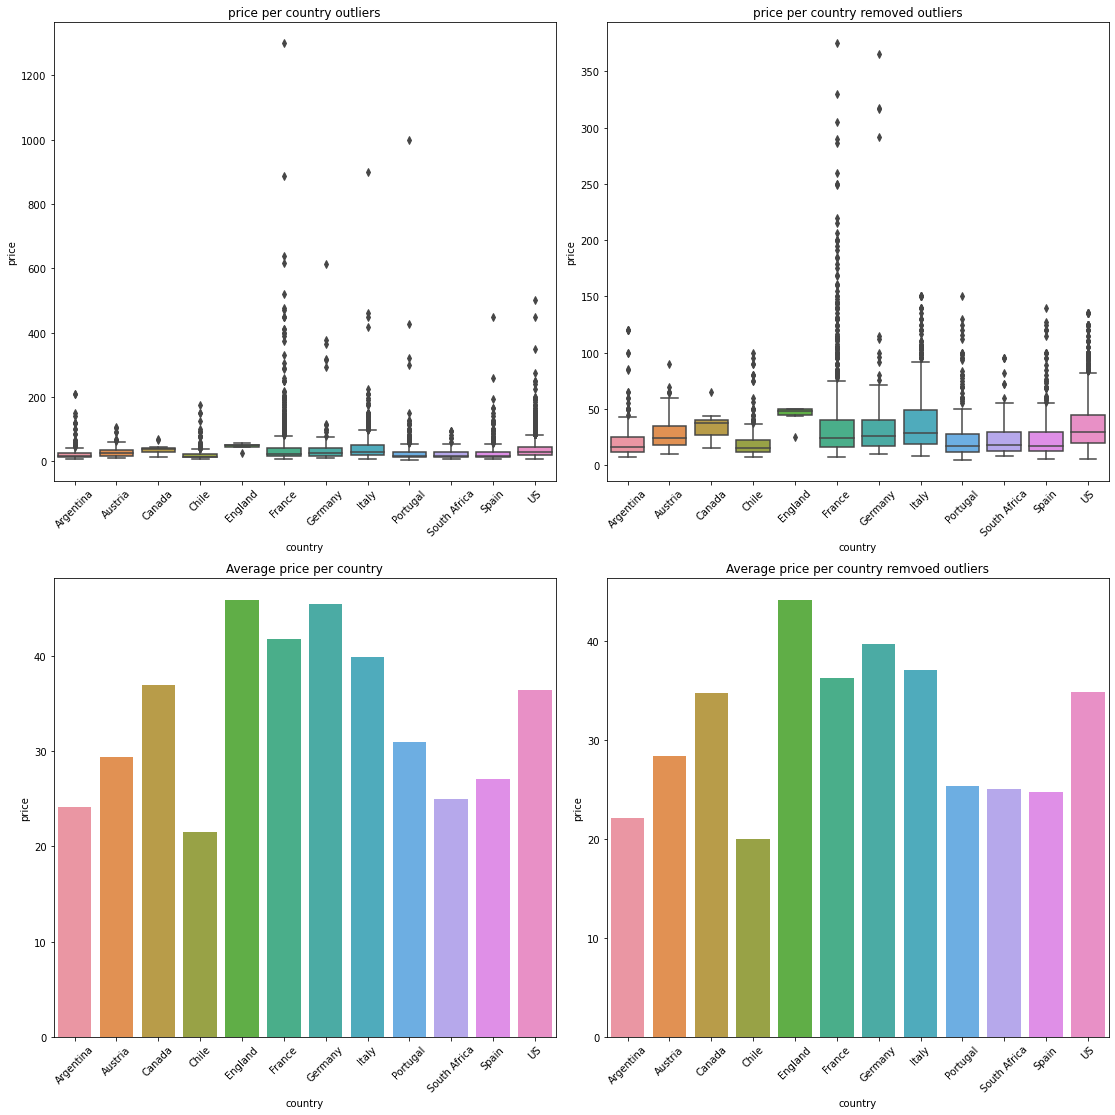

In [119]:
## Removing outliers
def outlieres_per_category(data:pd.DataFrame, category:str, outlieres:str, quantile_cutoff = 0.99):

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(len(data[category].unique())*1.3, 
                                                           len(data[category].unique())*1.3))
    data = data.sort_values(by = category)
    ax = sns.boxplot(x = data[category], y = data.price, ax = axs[0][0])
    ax.set_xticklabels(labels = data[category].unique(), rotation = 45)
    ax.set_title(f"{outlieres} per {category} outliers")

    average_price = data.groupby(category).mean()

    ax = sns.barplot(x = average_price.index, y = average_price[outlieres], ax = axs[1][0])
    ax.set_xticklabels(labels = data[category].unique(), rotation = 45)
    ax.set_title(f"Average {outlieres} per {category}")

    for cat in data[category].unique():
        quantile = data[data[category] == cat][outlieres].quantile(quantile_cutoff)
        data = data[~((data[category] == cat) & (data[outlieres] > quantile))]

    ax = sns.boxplot(x = data[category], y = data.price, ax = axs[0][1])
    ax.set_xticklabels(labels = data[category].unique(), rotation = 45)
    ax.set_title(f"{outlieres} per {category} removed outliers")

    average_price = data.groupby(category).mean()
    
    ax = sns.barplot(x = average_price.index, y = average_price[outlieres], ax = axs[1][1])
    ax.set_xticklabels(labels = data[category].unique(), rotation = 45)
    ax.set_title(f"Average {outlieres} per {category} remvoed outliers")

    fig.tight_layout()
    
    return axs, average_price

country_slice = wine[wine["country"].isin(wine[wine["price"].isna()].country.unique())].dropna(subset = ["country"])

axs, price_average = outlieres_per_category(country_slice, "country", "price", quantile_cutoff = 0.99)

### Categorical Features

In [230]:
## Checking the count of categorical features
## To decide on encoding method#
## Neglecting twitter_handel, as it should hold the same information like the taster name. 
## Taster Name, however, is not missing as many value

print(f"country: {len(wine['country'].unique())} -> One-Hot-Encoding")
print(f"taster_name: {len(wine['taster_name'].unique())} -> One-Hot-Encoding")
print(f"variety: {len(wine['variety'].unique())} -> Ordinal Encoding")
print(f"province: {len(wine['province'].unique())} -> Ordinal Encoding")
print(f"winery: {len(wine['winery'].unique())} -> Ordinal Encoding")

country: 38 -> One-Hot-Encoding
taster_name: 19 -> One-Hot-Encoding
variety: 333 -> Ordinal Encoding
province: 249 -> Ordinal Encoding
winery: 5460 -> Ordinal Encoding


## NLP

In [246]:
tokenizer = LemmaTokenizer()

tokenizer(wine.iloc[0]["description"])
wine["description_tok"] = wine["description"].apply(lambda txt: tokenizer(txt))
wine

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,description_tok
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner,"[fragrance, suggest, hay, crushed, tomato, vin..."
1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils,"[packed, fruit, crisp, acidity, bright, light,..."
2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole,"[easy, ruby, red, wine, display, fresh, berry,..."
3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family,"[pretty, violet, rose, petal, lower, octane, p..."
4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield,"[golden, wine, confounds, mix, wet, stone, car..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,France,"The fruit bursts out of the glass, while the s...",NaN,92,NaN,Burgundy,Echézeaux,NaN,Roger Voss,@vossroger,Bouchard Aîné & Fils 2005 Echézeaux,Pinot Noir,Bouchard Aîné & Fils,"[fruit, burst, glass, supporting, tannin, give..."
9996,US,There's a noticeable tilt of barrel reduction ...,Magnolia,87,30.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Krutz 2014 Magnolia Pinot Noir (Sonoma Coast),Pinot Noir,Krutz,"[noticeable, tilt, barrel, reduction, wine, ke..."
9997,France,"This perfumed, herbal blend of Syrah and Grena...",Rosé in the Air,86,19.0,Provence,Côtes de Provence,NaN,Roger Voss,@vossroger,Château Roquefeuille 2016 Rosé in the Air Rosé...,Rosé,Château Roquefeuille,"[perfumed, herbal, blend, syrah, grenache, tig..."
9998,Spain,Berry candy and licorice aromas become more su...,NaN,88,32.0,Northern Spain,Toro,NaN,Michael Schachner,@wineschach,Monte Hiniesta 2009 Toro,Tinta de Toro,Monte Hiniesta,"[berry, candy, licorice, aroma, become, subtle..."


In [266]:
bag_of_words = dict()

for description_tok in wine["description_tok"]:
    
    for token in description_tok:
        
        if token in bag_of_words.keys():
            bag_of_words[token] = bag_of_words[token] + 1
        else:
            bag_of_words[token] = 1
            
bow = pd.DataFrame(index = bag_of_words.keys(), data = bag_of_words.values(), columns = ["Count"])
bow = bow.sort_values(by = "Count", ascending = False)
bow

,Count
wine,6389
flavor,5387
fruit,4971
aroma,3151
palate,3075
...,...
engulfs,1
lamartine,1
milly,1
bourguignon,1


In [288]:
print(f"Size of Vocabulary {len(bow)}")
print(f"Words only appearing once {len(bow[bow['Count'] == 1])}")
print(f"Words only found once make up {round((len(bow[bow['Count'] == 1])/len(bow))*100, 2)}%")

Size of Vocabulary 10515
Words only appearing once 4501
Words only found once make up 42.81%


Text(0.5, 1.0, 'Most Frequent Words')

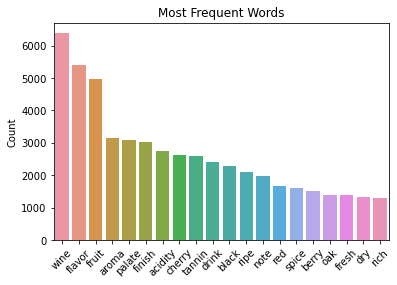

In [268]:
ax = sns.barplot(x = bow[:20].index, y = bow[:20]["Count"])
ax.set_xticklabels(labels = bow[:20].index, rotation = 45)
ax.set_title(f"Most Frequent Words")